In [4]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import random
import re
import matplotlib.pyplot as plt

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation
from keras.layers import GRU, SimpleRNN

This code imports the packages we will use. 

In [7]:
with open('/Users/maddiegupta/Desktop/trainENG.txt', 'r') as file:
    train_text = file.read()
    
with open('/Users/maddiegupta/Desktop/testENG.txt', 'r') as file:
    test_text = file.read()

vocabulary = sorted(list(set(train_text + test_text)))
vocab_size = len(vocabulary)

# Dictionaries to go from a character to index and vice versa
char_to_indices = dict((c, i) for i, c in enumerate(vocabulary))
indices_to_char = dict((i, c) for i, c in enumerate(vocabulary))

Here, we import our training data and testing data. 

In [10]:
def clean_text(text):
    # Remove the Byte Order Mark (BOM) if it exists
    cleaned_text = text.replace('\ufeff', '')
    
    # Remove unwanted characters (if any) using regular expressions
    # For example, removing digits, parentheses, and punctuation not needed:
    cleaned_text = re.sub(r'[^\w\s\'\n]', '', cleaned_text)
    
    # Optional: Remove any extra spaces or weird line breaks
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text
    
train_text = clean_text(train_text)
test_text = clean_text(test_text)

We also clean the files so they are ready for training. 

In [13]:
# 1000 characters of our training set
train_text[0:1000]

'seek one meantime you will remain here i have told our friend in the office that you are a lady slightly insane whom i am conveying to her friends so he will have an eye to your safety he smiled again and departed leaving delia overwhelmed with terror and despair she thought at first that she would run home at all hazards but she saw the baggage master watching her and she dared not attempt it he believed her insane and even if she told him her story he would not believe her she covered her face with her hands and burst into tears of agony but at that moment a strong hand was laid on her arm and a familiar voice said delia she looked up in amazement there stood mr fletcher wrapped in his long dark cloak his black hair dripping with the rain and his eyes like blazing fires delia he repeated what are you doing here delia had once feared mr fletcher more than any other ling being but now he seemed to her like an angel sent from heaven to her rescue she threw herself at his feet and excla

In [15]:
print("The vocabulary contains", vocab_size, "characters")
print("The training set contains", len(train_text) ,"characters")
print("The test set contains", len(test_text) ,"characters")

The vocabulary contains 44 characters
The training set contains 59521 characters
The test set contains 529 characters


Here's a peek at our training set. 

In [18]:
#prepare one hot encoding with train_data and train_labels from train_text
sequence_length = 100  # Length of each sequence (you can adjust this)

# Prepare input and output sequences
train_data = []
train_labels = []

for i in range(0, len(train_text) - sequence_length):
    # Get a sequence of characters as input
    input_seq = train_text[i: i + sequence_length]
    # Get the next character as the target label
    label = train_text[i + sequence_length]
    
    # Convert the input sequence into a list of indices (from char_to_indices)
    input_seq_indices = [char_to_indices[char] for char in input_seq]
    
    # Append to the training data
    train_data.append(input_seq_indices)
    
    # Append the label (as an index)
    train_labels.append(char_to_indices[label])

# Now we need to one-hot encode the data and labels
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Convert train_data to one-hot encoding
train_data_one_hot = np.zeros((len(train_data), sequence_length, vocab_size), dtype=bool)

for i, seq in enumerate(train_data):
    for t, char_idx in enumerate(seq):
        train_data_one_hot[i, t, char_idx] = 1

# Convert train_labels to one-hot encoding
train_labels_one_hot = np.zeros((len(train_labels), vocab_size), dtype=bool)

for i, label_idx in enumerate(train_labels):
    train_labels_one_hot[i, label_idx] = 1

This code prepares input and output sequences from `train_text` for training a character-based neural network model. It first converts character sequences into their respective indices based on a predefined character-to-index mapping (`char_to_indices`). Then, it transforms both the input data (`train_data`) and labels (`train_labels`) into one-hot encoded matrices, where each character is represented as a binary vector, enabling the model to understand each character's unique identity in the training process.

In [21]:
# load json and create model
json_file = open('/Users/maddiegupta/Desktop/q2_data/GRU_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json)
GRU_model.load_weights("/Users/maddiegupta/Desktop/q2_data/GRU_model.h5")

This code loads a pre-trained GRU model from a JSON file and its corresponding weights from an H5 file. It first reads the model's architecture from the JSON file and reconstructs the model using `model_from_json`. Then, it loads the model's saved weights from the specified H5 file, allowing you to use or further train the model without having to recompile or retrain it from scratch.

In [24]:
# Compile the GRU model with a loss function and optimizer
GRU_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Graphing the loss at each epoch to see the ideal training level 
# Fine-tune the model and save the training history
history = GRU_model.fit(train_data_one_hot, train_labels_one_hot, validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1486/1486 [==============================] - 815s 548ms/step - loss: 2.2971 - val_loss: 1.9378
Epoch 2/5
1486/1486 [==============================] - 981s 661ms/step - loss: 1.8141 - val_loss: 1.7857
Epoch 3/5
1486/1486 [==============================] - 818s 550ms/step - loss: 1.6108 - val_loss: 1.6715
Epoch 4/5
1486/1486 [==============================] - 760s 511ms/step - loss: 1.4597 - val_loss: 1.6600
Epoch 5/5
1486/1486 [==============================] - 872s 587ms/step - loss: 1.3184 - val_loss: 1.6647


This code compiles and trains the loaded GRU model with the Adam optimizer and categorical cross-entropy loss, which is suitable for multi-class classification problems. The model is fine-tuned on the prepared training data (`train_data_one_hot` and `train_labels_one_hot`) over 5 epochs with a batch size of 32, and 20% of the data is set aside for validation to monitor performance during training. The `history` object stores the loss and validation loss for each epoch, which can be graphed later to visualize the model’s learning progression and identify the ideal training level.

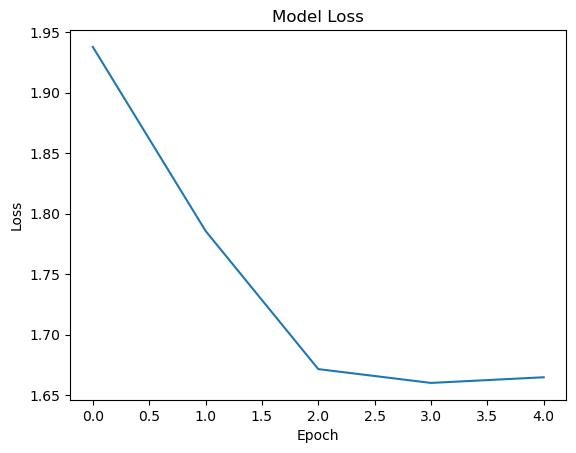

In [26]:
# Plot the loss at each epoch
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now, we plot the loss by epoch for the model. Each epoch represents another pass over the data by the model. We want the epoch where the lowest loss is, indicating that the model is learning but not memorizing the data. You can see the lowest loss for the English model is at 3 epochs. 

In [28]:
# retraining with the ideal epochs we found
json_file = open('/Users/maddiegupta/Desktop/q2_data/GRU_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

GRU_model = model_from_json(loaded_model_json)
GRU_model.load_weights("/Users/maddiegupta/Desktop/q2_data/GRU_model.h5")

GRU_model.compile(optimizer='adam', loss='categorical_crossentropy')

history = GRU_model.fit(train_data_one_hot, train_labels_one_hot, validation_split=0.2, epochs=3, batch_size=32)

Epoch 1/3
1486/1486 [==============================] - 835s 561ms/step - loss: 2.3220 - val_loss: 2.0566
Epoch 2/3
1486/1486 [==============================] - 1528s 1s/step - loss: 1.9107 - val_loss: 1.8533
Epoch 3/3
1486/1486 [==============================] - 1080s 727ms/step - loss: 1.7281 - val_loss: 1.7465


In [35]:
# Helper function
weights_GRU = GRU_model.get_weights()


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sample_text_GRU(weights, prompt, N):
    '''
    Uses a pretrained GRU to generate text, starting from a prompt,
    only using the weights and numpy commands
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    prompt (string): Start of generated sentence
                    N (int): Total length of output sentence
            Returns:
                    output_sentence (string): Text generated by GRU
    '''
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides
    
    # GRU Layer 
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))
    
    # -----------------------------------------------
    m = len(prompt)
    # Initiate the output sentence
    char_ind = char_to_indices[prompt[0]]
    x = np.zeros((vocab_size, 1))
    x[char_ind] = 1
    output_sentence = prompt[0]

    for t in range(1, N):
        # Calculate update and reset gates
        Gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        Gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        
        # Calculate hidden states
        c = np.tanh(np.dot(W_hx, x) + Gamma_r *  np.dot(W_hh, h) + b_h)
        h = Gamma_u * h + (1 - Gamma_u) * c
        
        # No prediction necessary, just add next char in the prompt
        if t < m:
            char_ind = char_to_indices[prompt[t]]
            output_sentence += prompt[t]
            
        # Predict the next character and add to output sentence
        if t >= m:
            # Calculate the output states
            y = np.dot(W_y, h) + b_y
            # Calculate the probability distribution
            p = np.exp(y) / np.sum(np.exp(y))
            # Sample next character in sentence
            char_ind = np.random.choice(range(vocab_size), p=p.ravel())
            pred_char = indices_to_char[char_ind]
            output_sentence += pred_char
            
        # Obtain the one-hot encoding of next character
        x = np.zeros((vocab_size, 1))
        x[char_ind] = 1
        
    return output_sentence

The `sample_text_GRU` function generates text from a pre-trained GRU model, beginning with a prompt and only relying on the provided model weights and NumPy operations, rather than a deep learning library. It starts by organizing the GRU weights into specific matrices for the update gate, reset gate, and candidate hidden state, reflecting the GRU’s unique mechanism for processing sequences. The function then initializes a zeroed hidden state and encodes the first character of the prompt to begin generating. For each time step, it calculates the GRU’s update and reset gates and computes a new hidden state based on the current input character and previous hidden state. If still processing within the length of the prompt, it simply uses the next character in the prompt; afterward, it predicts the next character by calculating a probability distribution over possible characters and sampling from it. Through these steps, the function progressively builds the output sentence, enabling text generation based on the GRU model’s trained parameters in an environment where a lower-level implementation is required.

In [38]:
print(sample_text_GRU(weights_GRU, 
                      'mrs. oliver looked at herself in the glass. she gave a brief, sideways look',
                      1000))

mrs. oliver looked at herself in the glass. she gave a brief, sideways look dropp asper she was from don't assoserouh seegned her and anpos resspreafes and poor the stared lotkdshand her and she sed not buths myss me duls be nomer very mr hrd lodenthis bnongh cacken thatkhed i drdhn and come not regap and pomrrood hebrels depress for rngs mrus sards mnmaninn emrd pomrrougs not her thll her ard and deder himple so profdorsinndabred that her remirs masond her and mrknnge for rnught mrs pomeroy and mighingher youss dile snrucked nut to mrr masknss room had neveront domernad youry but stelvinle she demI her remanessld moself her prosed the hadd has notlave drof she had roor soming aglirss to dearred come of fer anro mrd shecher amarnss for repureserent onsor howims and bus hod and fll her of comed she redres repared she corrsellare allmrs poor reponersover insher dournd the doorables lrngss dol's hel dass busd bighmed to tor hrd knowhactspond ar and room actent mas regand dring rencend mrs

The generated text is not as good as the N-Gram, but it does have some english words and follows an english sentence structure. Words like "come" and "poor" pop out well, indicating that shorter words may have done better. It works decently for being such a small training set and training from scratch with the GRU. 

In [40]:
#test with training text 

def evaluate_GRU_on_test(weights, test_text, N):
    '''
    Evaluates how well the GRU model performs on the test_text
            Parameters:
                    weights (list): Weights of the pretrained GRU model
                    test_text (string): Test text to compare against generated text
                    N (int): Number of characters to generate
            Returns:
                    accuracy (float): Accuracy of the model on the test text
    '''
    correct_predictions = 0
    total_predictions = 0
    
    # Choose a starting prompt from the test text
    prompt_length = 10  # You can vary this value
    for i in range(len(test_text) - prompt_length - N):
        prompt = test_text[i:i+prompt_length]
        true_text = test_text[i+prompt_length:i+prompt_length+N]
        
        # Generate text using the GRU model
        generated_text = sample_text_GRU(weights, prompt, N)
        
        # Compare generated text to the actual test text
        for j in range(min(len(generated_text), len(true_text))):
            if generated_text[j] == true_text[j]:
                correct_predictions += 1
            total_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

The `evaluate_GRU_on_test` function assesses how accurately a pre-trained GRU model generates text that matches a given `test_text` string. It starts by selecting multiple prompts from `test_text`, each with a predefined `prompt_length`, and then generates text based on these prompts using the `sample_text_GRU` function. For each generated character, the function compares it to the corresponding character in the actual text and records the number of correct matches. The total number of predictions is tallied, and the function calculates the accuracy as the ratio of correct predictions to total predictions. This accuracy value represents the GRU model's effectiveness in replicating the structure and content of the test text.

In [42]:
N = 100  # Number of characters to generate
accuracy = evaluate_GRU_on_test(weights_GRU, test_text, N)
print(f"Model accuracy on test text: {accuracy:.2f}")

Model accuracy on test text: 0.07


The accuracy of 7% could be worse. It means a 7% improvement over having no information, and could save users 7% of their keystrokes given an autocomplete feature use for this model. 

In [209]:
def perplexity_GRU(weights, test_data, m):
    # Extracting weights and biases
    # Dimensions of matrices are same format as lecture slides
    
    # GRU Layer 
    W_ux, W_rx, W_hx = np.split(weights[0].T, 3, axis = 0)
    W_uh, W_rh, W_hh = np.split(weights[1].T, 3, axis = 0)

    bias = np.sum(weights[2], axis=0)
    b_u, b_r, b_h = np.split(np.expand_dims(bias, axis=1), 3)

    # Linear (dense) layer
    W_y = weights[3].T
    b_y = np.expand_dims(weights[4], axis=1)
    
    # Initiate hidden state
    h = np.zeros((W_hh.shape[0], 1))
    
    # -----------------------------------------------
    prompt = test_data[0:m]
    N = len(test_data)
    # Initiate array of probabilities
    p_array = np.zeros(N-m)
    char_ind = char_to_indices[prompt[0]]
    x = np.zeros((vocab_size, 1))
    x[char_ind] = 1

    for t in range(1, N):
        # Calculate update and reset gates
        Gamma_u = sigmoid(np.dot(W_ux, x) + np.dot(W_uh, h) + b_u)
        Gamma_r = sigmoid(np.dot(W_rx, x) + np.dot(W_rh, h) + b_r)
        
        # Calculate hidden states
        c = np.tanh(np.dot(W_hx, x) + Gamma_r * np.dot(W_hh, h) + b_h)
        h = Gamma_u * h + (1 - Gamma_u) * c
        
        # No prediction necessary, just add next char in the prompt
        if t < m:
            char_ind = char_to_indices[test_data[t]]
            
        # Predict the next character and add to output sentence
        if t >= m:
            # Calculate the output states
            y = np.dot(W_y, h) + b_y
            # Calculate the probability distribution
            p = np.exp(y) / np.sum(np.exp(y))
            # Get the next character in the test set
            char_ind = char_to_indices[test_data[t]]
            # Add the probability corresponding to test sequence to list
            p_array[t-m] = p[char_ind]
            
        # Obtain the one-hot encoding of next character
        x = np.zeros((vocab_size, 1))
        x[char_ind] = 1

    return np.log(p_array), np.exp((-1/(N-m)) * np.sum(np.log(p_array)))

The `perplexity_GRU` function calculates the perplexity of a GRU model on test data, a measure of the model’s ability to predict sequences. It begins by organizing the GRU weights, initializing the hidden state, and preparing the prompt from the `test_data`. For each character, it updates the GRU’s hidden state and predicts the probability distribution for the next character. The probability of the true next character in the sequence is recorded for each step. Finally, it calculates perplexity by exponentiating the average negative log-probability of these recorded probabilities, providing a single metric that reflects the model’s predictive accuracy. Lower perplexity indicates better predictive performance.

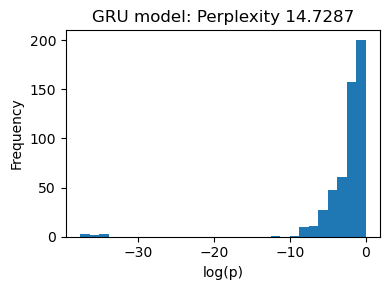

In [213]:
# Create a single plot
plt.figure(figsize=(4, 3))

# Plot the histogram
plt.hist(p_GRU, bins=30)

# Add title and labels
plt.title(f"GRU model: Perplexity {np.round(per_GRU, 4)}")
plt.xlabel("log(p)")
plt.ylabel("Frequency")

# Show the plot
plt.tight_layout()
plt.show()

Overall, the perplexity of the GRU model for english is fairly low, at around 15. This indicates the model is working pretty well. We can also see this visually with the output. Although it isn't perfect, it produces english words in order. For the size of the model, that is promising. Next, we will see how it compares to the Anishinaabemowin GRU. 